# Policy Vulnerability Analysis

This notebook repeats the steps of Scenario Discovery, but focuses on understanding scenarios where the proposed policies may fail, helping our Client comprehend the conditions under which the policies might be ineffective.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import load_results, ema_logging, MultiprocessingEvaluator, Policy, Scenario
from ema_workbench.analysis import prim
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
import copy

In [2]:
# Instantiate the model
ema_logging.log_to_stderr(ema_logging.INFO)

# Policy formulation number 1 is chosen, as this is in line with the intrest of our client the Delta Commision
dike_model, planning_steps = get_model_for_problem_formulation(6)

uncertainties = copy.deepcopy(dike_model.uncertainties)

levers = copy.deepcopy(dike_model.levers)

outcomes = copy.deepcopy(dike_model.outcomes)

In [3]:
# import the policies from the Policy Robustness analysis
results_robustness = pd.read_csv('data/final_policies.csv')

# drop the unnecessary columns and save the dataframe policy_df
policies_df = results_robustness.drop(columns=['Unnamed: 0', 'model', 'policy'])
policies_df

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,1,0,1,0,0,0,1,1,1,1,...,0,3,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,6,0,0,7,0,0,6,0,0
2,1,1,0,0,0,0,1,0,1,1,...,0,4,3,0,10,4,2,4,0,3
3,0,0,0,0,0,1,1,1,1,0,...,0,4,0,0,10,4,2,7,1,0


In [4]:
# Import the scenarios from the PRIM analysis 
scenarios_df = pd.read_csv('data/prim_results_box.csv')

# drop the unnecessary columns   
scenarios_df = scenarios_df.drop(columns=['Unnamed: 0'] + [outcome.name for outcome in dike_model.outcomes] + ['scenario'] + [lever.name for lever in dike_model.levers])

scenarios_df.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
0,125,323.748619,1.0,0.348941,162.310684,1.5,0.119125,79.367400,10.0,0.001792,311.909964,1.5,0.668484,276.362094,1.0,0.325291,2.5,3.5,4.5
1,37,286.824604,1.5,0.282438,222.710392,1.0,0.466771,92.315255,1.0,0.081138,340.743357,1.5,0.058861,323.405438,1.5,0.541447,4.5,2.5,3.5
2,16,134.323752,1.0,0.602434,196.924355,1.5,0.302187,343.165892,1.5,0.059988,294.888697,1.5,0.323833,94.552293,1.5,0.844812,1.5,4.5,4.5
3,55,184.601087,1.5,0.669015,215.668512,1.5,0.467809,230.624844,1.0,0.107615,76.195186,10.0,0.078854,277.297992,10.0,0.759760,1.5,3.5,1.5
4,3,112.468853,10.0,0.703181,62.322361,1.0,0.553291,173.485977,10.0,0.101375,283.997387,1.0,0.675002,143.964366,10.0,0.525508,4.5,1.5,4.5


In [5]:
scenarios = [] # create empty list to store scnearios

for i, scenario in scenarios_df.iterrows():
    scenario_dict = scenario.to_dict() # convert scenario to dictionary
    unique_name = f"scenario_{i}"  # Creating a unique name for each scenario
    scenarios.append(Scenario(name=unique_name, **scenario_dict)) # append the scenario to the list

In [6]:
policies = [] # create empty list to store policies

for i, policy in policies_df.iterrows():
    policy_dict = policy.to_dict() # convert policy to dictionary
    unique_name = f"policy_{i}"  # Creating a unique name for each policy
    policies.append(Policy(name=unique_name, **policy_dict)) # append policy to list

In [7]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=scenarios, policies=policies)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 7409 scenarios * 4 policies * 1 model(s) = 29636 experiments
100%|██████████████████████████████████| 29636/29636 [1:36:51<00:00,  5.10it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [8]:
# convert to dataframes 
experiments = pd.DataFrame(experiments)
outcomes = pd.DataFrame(outcomes)

# Combine experiments and outcomes
results = pd.concat([experiments, outcomes], axis=1)

# There are 7409 scenarios in the prim box * 5 policies = 37450 experiments runned
results.shape

(29636, 59)

In [9]:
# as can be seen, all experiments have different policy and scenario combinations
experiments.head()

,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,2.5,3.5,4.5,125,323.748619,0.348941,1.0,162.310684,0.119125,1.5,...,0,0,0,0,0,0,0,scenario_0,policy_0,dikesnet
1,4.5,2.5,3.5,37,286.824604,0.282438,1.5,222.710392,0.466771,1.0,...,0,0,0,0,0,0,0,scenario_1,policy_0,dikesnet
2,1.5,4.5,4.5,16,134.323752,0.602434,1.0,196.924355,0.302187,1.5,...,0,0,0,0,0,0,0,scenario_2,policy_0,dikesnet
3,1.5,3.5,1.5,55,184.601087,0.669015,1.5,215.668512,0.467809,1.5,...,0,0,0,0,0,0,0,scenario_3,policy_0,dikesnet
4,4.5,1.5,4.5,3,112.468853,0.703181,10.0,62.322361,0.553291,1.0,...,0,0,0,0,0,0,0,scenario_4,policy_0,dikesnet


# PRIM 

In [30]:
KPIs = ['Expected Number of Deaths', 'Expected Annual Damage', 'Dike Investment Costs', 'RfR Total Costs', 'Expected Evacuation Costs']
main_KPI = 'Expected Number of Deaths'

In [31]:
# define uncertanties 
uncertainties = ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2']

In [32]:
# Separate features (x) and outcomes (y)
x = results.loc[:, uncertainties]
y = outcomes[main_KPI]

In [50]:
# So, the 80th percentile is used
eighty_quantile = y.quantile(0.6)

# Ensure y is binary
y_binary = (y > eighty_quantile).astype(int).values

In [51]:
ema_logging.log_to_stderr(ema_logging.INFO)

# By setting the threshold to 0.75, the PRIM algorithm is instructed to find boxes 
# where at least 75% of the data points within the box are greater than the 80th percentile.
# This helps ensure that the identified boxes are highly relevant and contain a significant proportion of the desired outcomes.

# 0.75 is the max threshold that still gives boxes
prim_alg = prim.Prim(x, y_binary, threshold=0.75, peel_alpha=0.1)
box1 = prim_alg.find_box()

[MainProcess/INFO] 29636 points remaining, containing 11821 cases of interest
[MainProcess/INFO] mean: 0.9993489583333334, mass: 0.05182885679578891, coverage: 0.12985365028339396, density: 0.9993489583333334 restricted_dimensions: 1


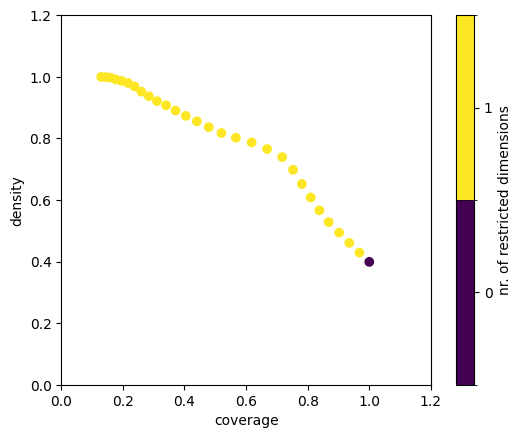

In [52]:
box1.show_tradeoff()
plt.show()

Density (y-axis): Represents the proportion of scenarios that are relevant to high expected number of deaths. Higher density indicates that the box is mostly composed of cases with high expected Number of Deaths.

Coverage (x-axis): Shows the proportion of all relevant cases captured by the scenario. Higher coverage means the scenario includes a greater fraction of all potential cases of interest.

In [53]:
# look at the cases where coverage is higher than 0.8 and density is higher than 0.6
potentials = box1.peeling_trajectory
potentials = potentials[(potentials.coverage > 0.8)
                         & (potentials.density > 0.6)]
potentials

,coverage,density,id,k,mass,mean,n,res_dim
6,0.809915,0.608105,6,9574,0.531246,0.608105,15744,1


In [54]:
chosen_box = potentials[potentials.density == potentials.density.max()]
chosen_box_id = int(chosen_box.iloc[0].name)
chosen_box_id

6

In [55]:
chosen_box

,coverage,density,id,k,mass,mean,n,res_dim
6,0.809915,0.608105,6,9574,0.531246,0.608105,15744,1


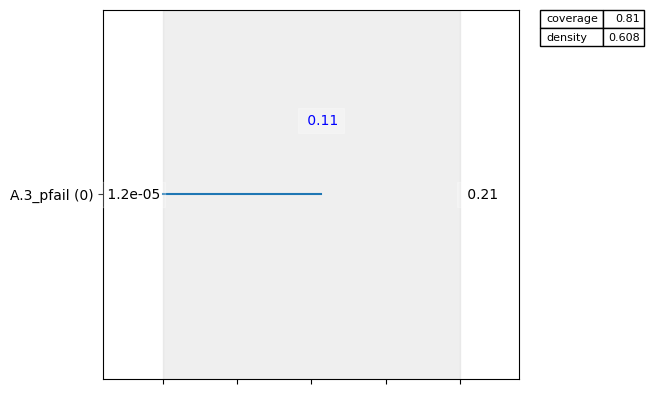

In [56]:
box1.select(chosen_box_id)
box1.inspect(style='graph')
plt.show()

### Interpretation of the PRIM Analysis Box

The presented PRIM (Patient Rule Induction Method) analysis box focuses on the parameter A.3_pfail, which represents the probability of failure for dike ring A3. This analysis was conducted using the four most robust policies applied to the scenarios within the most critical scenario box found in the scenario discovery with no policy interventions.

#### Key Points of the Box Analysis:

1. **Parameter of Interest: A.3_pfail**
   - **Range:** The x-axis shows the range of A.3_pfail from approximately 1.2e-05 to 0.21.
   - **Box Constraint:** The horizontal bar within the shaded region indicates the range of A.3_pfail values that define this PRIM box.
   - **Central Value:** The central value of 0.11 is highlighted, representing the median or central tendency within this constrained range.

2. **Coverage and Density:**
   - **Coverage:** The top right of the plot indicates a coverage value of 0.81. This means that the identified box captures 81% of all high-risk scenarios (scenarios with high expected deaths) in the dataset. High coverage indicates that this box is representative of the majority of critical scenarios.
   - **Density:** The density value is 0.608, showing that 60.8% of the scenarios within this box are indeed high-risk. This value suggests a high concentration of relevant cases, making the box specific to the outcome of interest (high expected deaths).

3. **Interpretation of the Range:**
   - **Critical Range:** The critical range for A.3_pfail is between 1.2e-05 and 0.21. Within this range, the scenarios tend to be high-risk despite the application of the most robust policies. The relatively wide range implies that there is significant variability in the risk associated with A.3_pfail, but any value within this range is associated with increased vulnerability.
   - **Impact of Policies:** Despite the application of the four most robust policies, the scenarios within this box remain high-risk due to the inherent vulnerability associated with the failure probability of dike ring A3.

4. **Robust Policy Implications:**
   - **Policy Focus:** The analysis suggests that even with robust policies in place, particular attention must be paid to the structural integrity and failure probabilities of dike ring A3. The robustness of policies can be compromised if the failure probability falls within this identified critical range.
   - **Mitigation Strategies:** Additional measures may be required to further reduce the failure probability of dike ring A3 or to implement supplementary interventions that can mitigate the high-risk outcomes identified in this range.

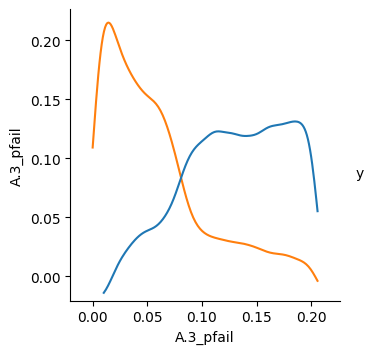

In [72]:
# select a specific box 
box1.select(chosen_box_id)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(4,4)
plt.show()

#### Interpretation of Density Plot

- **Density within the PRIM Box (Blue Line)**:
  - The blue density line starts near zero and rises steadily, reaching a peak around **A.3_pfail** value of approximately 0.1. This suggests that within the PRIM box, a significant number of scenarios have **A.3_pfail** values around this point.
  - After reaching the peak, the density decreases, indicating fewer scenarios with higher **A.3_pfail** values. The drop-off suggests that extreme failure probabilities are less common within the PRIM box.

- **Density outside the PRIM Box (Orange Line)**:
  - The orange density line starts high and then quickly decreases as **A.3_pfail** values increase. This indicates that outside the PRIM box, a large number of scenarios have low **A.3_pfail** values.
  - The density remains low for higher values of **A.3_pfail**, implying that outside the PRIM box, scenarios with high probabilities of dike failure are less frequent.
  
- **Overlap and Divergence**:
  - At low values of **A.3_pfail** (close to 0), the orange line (outside box) is significantly higher than the blue line (inside box), indicating that low failure probabilities are more common outside the high-risk scenarios identified by the PRIM box.
  - Around **A.### Interpretation of the Density Distribution Plot for A.3_pfail

The density distribution plot for A.3_pfail provides insight into how the failure probability of dike ring A3 affects the risk levels under the application of the four most robust policies. This analysis helps to understand the distribution of high-risk and low-risk scenarios based on this critical parameter.

#### Key Points of the Density Distribution Plot:

1. **Parameter of Interest: A.3_pfail**
   - **X-Axis:** Represents the failure probability of dike ring A3 (A.3_pfail), ranging from 0.00 to 0.20.
   - **Y-Axis:** Shows the density (frequency) of scenarios for both high-risk (orange line) and low-risk (blue line) outcomes.

2. **Density Curves:**
   - **High-Risk Scenarios (Orange Line):** The density curve for high-risk scenarios indicates the probability distribution where A.3_pfail contributes to high expected deaths.
   - **Low-Risk Scenarios (Blue Line):** The density curve for low-risk scenarios shows the distribution of scenarios where A.3_pfail contributes to lower expected deaths.

3. **Interpretation of the Curves:**
   - **High Density of High-Risk Scenarios at Low A.3_pfail:** The orange line peaks at lower values of A.3_pfail, indicating that high-risk scenarios are more frequent when the failure probability of dike ring A3 is low (around 0.03). This suggests that even a small probability of failure can lead to significant risks.
   - **Low-Risk Scenarios:** The blue line increases with A.3_pfail, suggesting that as the failure probability increases, the scenarios tend to shift towards lower risk, possibly due to the robustness of the applied policies.
   - **Intersection Point:** The point where the blue and orange lines intersect (around A.3_pfail = 0.10) indicates a transition zone. Here, the likelihood of high-risk and low-risk scenarios is balanced, marking a critical threshold for this parameter.

4. **Risk Management Implications:**
   - **Critical Range for Interventions:** The plot highlights the critical range of A.3_pfail (from 0.00 to 0.10) where the focus should be on reducing the failure probability to lower high-risk outcomes. Targeted interventions in this range can significantly mitigate flood risks.
   - **Policy Effectiveness:** The analysis shows that robust policies tend to perform better at higher values of A.3_pfail, but attention must be given to low-probability, high-impact events that occur at lower values.


In [64]:
# Inspect the parameter limits from the chosen box.
limits = box1.box_lims[chosen_box_id]
limits

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
0,0,30.071010,"{1.0, 10.0, 1.5}",0.096175,30.010405,"{1.5, 10.0, 1.0}",0.000133,30.020101,"{1.0, 10.0, 1.5}",0.000012,30.006324,"{1.5, 10.0, 1.0}",0.000117,30.062884,"{1.0, 10.0, 1.5}",0.000097,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"
1,132,349.975691,"{1.0, 10.0, 1.5}",0.999961,349.831128,"{1.5, 10.0, 1.0}",0.999904,349.982975,"{1.0, 10.0, 1.5}",0.109426,349.988486,"{1.5, 10.0, 1.0}",0.999568,349.961494,"{1.0, 10.0, 1.5}",0.999949,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"


In [65]:
# Interpret the limits of the box
# The limits of the box are the minimum and maximum values of the parameters that define the box.

print("Uncertainties limits of the box:")
for param, (lower_bound, upper_bound) in limits.items():
    print(f"{param}: {lower_bound} to {upper_bound}")

Uncertainties limits of the box:
A.0_ID flood wave shape: 0 to 132
A.1_Bmax: 30.07100989790265 to 349.97569085582336
A.1_Brate: {1.0, 10.0, 1.5} to {1.0, 10.0, 1.5}
A.1_pfail: 0.0961753528783659 to 0.9999612760519778
A.2_Bmax: 30.01040451227581 to 349.8311280459608
A.2_Brate: {1.5, 10.0, 1.0} to {1.5, 10.0, 1.0}
A.2_pfail: 0.0001327242575921 to 0.9999036218147468
A.3_Bmax: 30.020101355285707 to 349.9829752706704
A.3_Brate: {1.0, 10.0, 1.5} to {1.0, 10.0, 1.5}
A.3_pfail: 1.1688779985953123e-05 to 0.10942627475517064
A.4_Bmax: 30.00632414624865 to 349.988486359521
A.4_Brate: {1.5, 10.0, 1.0} to {1.5, 10.0, 1.0}
A.4_pfail: 0.000116868955194 to 0.9995681126668862
A.5_Bmax: 30.062884008396697 to 349.9614936252338
A.5_Brate: {1.0, 10.0, 1.5} to {1.0, 10.0, 1.5}
A.5_pfail: 9.678963604166772e-05 to 0.9999490172692844
discount rate 0: {1.5, 2.5, 3.5, 4.5} to {1.5, 2.5, 3.5, 4.5}
discount rate 1: {1.5, 2.5, 3.5, 4.5} to {1.5, 2.5, 3.5, 4.5}
discount rate 2: {1.5, 2.5, 3.5, 4.5} to {1.5, 2.5, 3.5

In [67]:
# Usage of limits
# Filter the results of all experiments to only include the experiments that fall within the box limits
# Only filter on the uncertainties that influence the box
results_box = results[
    (results['A.3_pfail'] >= limits['A.3_pfail'][0]) & (results['A.3_pfail'] <= limits['A.3_pfail'][1])
]

results_box.head()

,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,...,A.5_DikeIncrease 2,scenario,policy,model,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Investment Costs
0,2.5,3.5,4.5,125,323.748619,0.348941,1.0,162.310684,0.119125,1.5,...,0,scenario_0,policy_0,dikesnet,6.655067e+08,9.751348e+07,759800000.0,41115.728178,0.152803,8.573546e+08
1,4.5,2.5,3.5,37,286.824604,0.282438,1.5,222.710392,0.466771,1.0,...,0,scenario_1,policy_0,dikesnet,9.698962e+07,9.751348e+07,759800000.0,8029.665502,0.010688,8.573215e+08
2,1.5,4.5,4.5,16,134.323752,0.602434,1.0,196.924355,0.302187,1.5,...,0,scenario_2,policy_0,dikesnet,4.050789e+07,9.751348e+07,759800000.0,2479.998511,0.007365,8.573160e+08
3,1.5,3.5,1.5,55,184.601087,0.669015,1.5,215.668512,0.467809,1.5,...,0,scenario_3,policy_0,dikesnet,7.893916e+07,9.751348e+07,759800000.0,5130.190378,0.004092,8.573186e+08
4,4.5,1.5,4.5,3,112.468853,0.703181,10.0,62.322361,0.553291,1.0,...,0,scenario_4,policy_0,dikesnet,4.399839e+07,9.751348e+07,759800000.0,2957.202736,0.006240,8.573164e+08


In [69]:
# A lower quantile is used, so the box contains more scenarios than other PRIM analysis
print(f'There are {results_box.shape[0]} scenarios in the PRIM box.')

There are 15744 scenarios in the PRIM box.


In [71]:
# export the results box into a csv file
results_box.to_csv('./data/prim_results_box_vulnerability.csv', index = True)